<a href="https://colab.research.google.com/github/Ashwin-Rajesh/IEEE-Computer-Vision/blob/main/IEEE_Computer_Vision_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end computer vision applications

We saw basics of image processing. Let us see how to use these and some more algorithms to do some more awesome stuff!

Libraries :

- cv2
  - OpenCV for computer vision
- numpy
  - For representing matrices
- matplotlib
  - For showing images
- ipywidgets
  - For widgets, like sliders and numeric entry fields

In [102]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual

## 1) Lane detection for self driving cars

Detecting the lanes for self driving

In [103]:
!wget -O road.jpg https://raw.githubusercontent.com/Ashwin-Rajesh/IEEE-Computer-Vision/main/samples/road.jpg

--2022-03-04 17:05:33--  https://raw.githubusercontent.com/Ashwin-Rajesh/IEEE-Computer-Vision/main/samples/road.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48393 (47K) [image/jpeg]
Saving to: ‘road.jpg’

road.jpg            100%[===================>]  47.26K  --.-KB/s    in 0.01s   

2022-03-04 17:05:33 (4.69 MB/s) - ‘road.jpg’ saved [48393/48393]



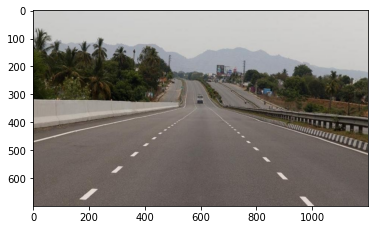

In [104]:
road_img = cv2.resize(cv2.cvtColor(cv2.imread("road.jpg"), cv2.COLOR_BGR2RGB), (1200, 700))

plt.imshow(road_img)
plt.show()

In [105]:
# Returns an image that has all the lines passed
def displayLines(image, lines, colour = (255,0,0)):
    line_image = image
    if(lines is not None):
        for line in lines:
            x1,y1,x2,y2 = line[0].astype(int)
            cv2.line(line_image, (x1,y1), (x2, y2), colour, 10)
    return line_image

def get_coords(y1, y2, line):
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return np.asarray([x1, y1, x2, y2])

# Returns the average of lines detected after splitting them as of left or right boundary based on their slope
def getAverageLines(image, lines):
    left_lines = []
    right_lines = []

    for line in lines:
        x1, y1, x2, y2 = np.reshape(line,4)
        para = np.polyfit((x1,x2),(y1,y2),1)
        m = para[0]
        b = para[1]
        if((abs(m) < 0.2) | (abs(m) > 20)):
            continue
        if(m > 0):
            right_lines.append(para)
        else:
            left_lines.append(para)
    
    if (len(left_lines) == 0):
        left_lines.append((0,0))

    if (len(right_lines) == 0):
        right_lines.append((0,0))

    return (get_coords(700, 400, np.average(left_lines, axis=0)), get_coords(700, 400, np.average(right_lines, axis=0)))

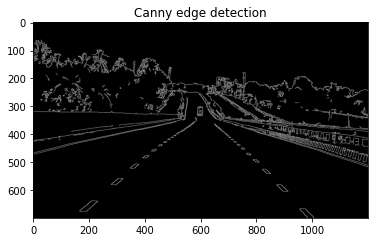

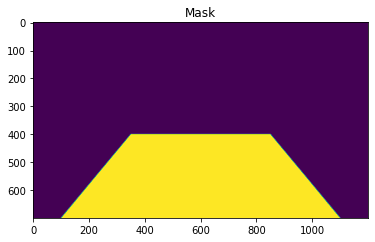

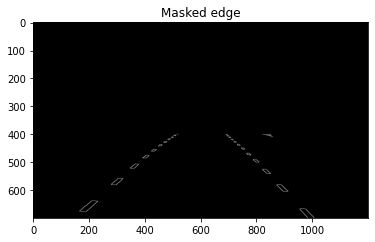

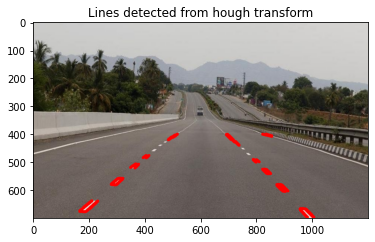

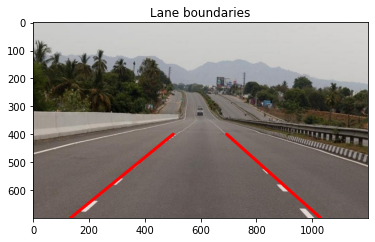

In [106]:
# First, canny edge detection
road_canny = cv2.Canny(road_img, 100, 200)
# Show edge detection results
plt.imshow(road_canny, cmap="gray")
plt.title("Canny edge detection")
plt.show()

# Creating a mask
road_mask_poly = np.array([[(100,700),(350,400),(850,400),(1100,700)]])  # Corners of the mask region
road_mask = np.zeros_like(road_canny)                             # Creating the mask
cv2.fillPoly(road_mask, road_mask_poly, 255)                           # Fill region of mask inside polygon with 255 
# Show mask
plt.imshow(road_mask)
plt.title("Mask")
plt.show()

# Applying the mask
road_edges = road_canny & road_mask

plt.imshow(road_edges, cmap="gray")
plt.title("Masked edge")
plt.show()

# Hough line detection
lines       = cv2.HoughLinesP(road_edges, 1, np.pi / 180, 10, minLineLength=10, maxLineGap=5) 
road_lines  = road_img.copy()
displayLines(road_lines, lines)
plt.imshow(road_lines)
plt.title("Lines detected from hough transform")
plt.show()

# Detect left and right lane lines
left_line, right_line = getAverageLines(road_img, lines)
road_lanes  = road_img.copy()
displayLines(road_lanes, [[left_line],[right_line]])
plt.imshow(road_lanes)
plt.title("Lane boundaries")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


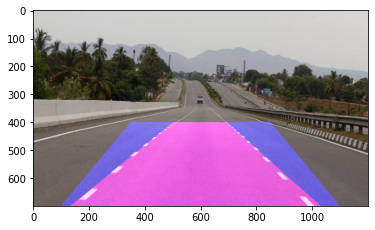

In [108]:
# Define the polygon for the lane from left line and right line coordinates
road_lane_poly = np.zeros((1,4,2))
road_lane_poly[0][0] = (left_line[0], left_line[1])
road_lane_poly[0][1] = (left_line[2], left_line[3])
road_lane_poly[0][2] = (right_line[2], right_line[3])
road_lane_poly[0][3] = (right_line[0], right_line[1])
road_lane_poly = road_lane_poly.astype(np.int)
# Find mask for the lane from the polygon
road_lane_mask = np.zeros_like(road_img)
cv2.fillPoly(road_lane_mask, road_lane_poly, (255, 0, 0))
# Find the mask for the ROI (Region Of Interest)
road_roi_mask  = np.zeros_like(road_img)
cv2.fillPoly(road_roi_mask, road_mask_poly, (0, 0, 255))
# Blend ROI (blue) and the lane region (red)
road_lane_img = cv2.addWeighted(road_img, 1, road_roi_mask, 0.5, 1)
road_lane_img = cv2.addWeighted(road_lane_img, 1, road_lane_mask, 0.5, 1)

plt.imshow(road_lane_img)
plt.show()